# IMAGE WARPING and MOSAICING

In [46]:
import cv2

import numpy as np
import skimage.io as skio

from skimage.draw import polygon
from Utils.ImagePointSet import ImagePointSet

## Recover Homographies

In [123]:
from scipy.interpolate import griddata
def computeProjectionMatrix(src_points, dest_points):
    # Stack them horizontally so least squares gives a nice 3x3 matrix
    homogenous_src_points = np.concatenate([src_points, np.ones((src_points.shape[0], 1))], axis=1)
    homogenous_dest_points = np.concatenate([dest_points, np.ones((dest_points.shape[0], 1))], axis=1)
    return np.linalg.lstsq(homogenous_src_points, homogenous_dest_points)[0].T

# Used to verify method
def wrap_image_with_cv2(image, projection_matrix):
    h, w, _ = image.shape
    output_size = (w, h)
    
    wrapped_image = cv2.warpPerspective(image, projection_matrix, output_size)
    
    return wrapped_image

def get_warpped_corners(image, projection_matrix):
    h, w, _ = image.shape
    image_corners = np.array([
        [0, 0, 1],
        [h, 0, 1],
        [0, w, 1],
        [h, w, 1]
    ]).T
    
    # Get corners of warped image
    warpped_corners = np.dot(projection_matrix, image_corners)
    warpped_corners /= warpped_corners[2]
    warpped_corner_x, warpped_corner_y = warpped_corners[0].astype(int), warpped_corners[1].astype(int)
    
    return warpped_corner_x, warpped_corner_y

def warp_image(image, projection_matrix):
    warpped_corner_x, warpped_corner_y = get_warpped_corners(image, projection_matrix)
    warped_shape = (np.max(warpped_corner_x) + 1, np.max(warpped_corner_y) + 1)
    warped_image = np.zeros((warped_shape[0], warped_shape[1], 3))
    
    warped_x, warped_y = polygon(warpped_corner_x, warpped_corner_y)
    homogenous_warped_coords = np.vstack((warped_x, warped_y, np.ones_like(warped_x)))
    homogenous_image_coords = np.linalg.inv(projection_matrix).dot(homogenous_warped_coords)
    homogenous_image_coords /= homogenous_image_coords[2]
    
    image_x, image_y = homogenous_image_coords[0].astype(int), homogenous_image_coords[1].astype(int)
    
    in_bounds_index = (
        (image_x >= 0) & (image_x < image.shape[0]) &
        (image_y >= 0) & (image_y < image.shape[1])
    )
    
    image_x, image_y = image_x[in_bounds_index], image_y[in_bounds_index]
    warped_x, warped_y = warped_x[in_bounds_index], warped_y[in_bounds_index]
    
    # Shift them to be positive
    warpped_min_x = np.min(warpped_corner_x)
    warpped_min_y = np.min(warpped_corner_y)
    warpped_corner_x -= (warpped_min_x * (warpped_min_x < 0))
    warpped_corner_y -= (warpped_min_y * (warpped_min_y < 0))
    
    warped_image[warped_x, warped_y, :] = image[image_x, image_y, :]
    
    return warped_image
  

(375, 500, 3) (123, 501, 3)


/var/folders/fh/_gx0g24s4tl16v34ypwltf0w0000gn/T/ipykernel_64893/2759133048.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(homogenous_src_points, homogenous_dest_points)[0].T


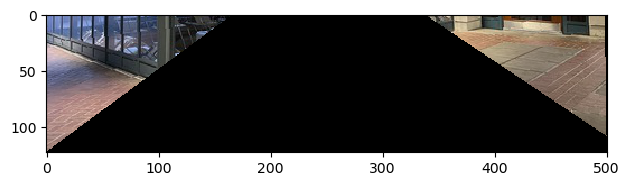

In [124]:
hallway0_hallway1 = ImagePointSet("hallway/hallway0_hallway1.json")
hallway0_hallway1_projection_matrix = computeProjectionMatrix(hallway0_hallway1.points[0], hallway0_hallway1.points[1])
wrapped_image = warp_image(hallway0_hallway1.images[0], hallway0_hallway1_projection_matrix)
print(hallway0_hallway1.images[0].shape, wrapped_image.shape)
skio.imshow(wrapped_image)
skio.show()

(375, 500, 3) (375, 500, 3)


/var/folders/fh/_gx0g24s4tl16v34ypwltf0w0000gn/T/ipykernel_64893/3027178312.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(homogenous_src_points, homogenous_dest_points)[0].T


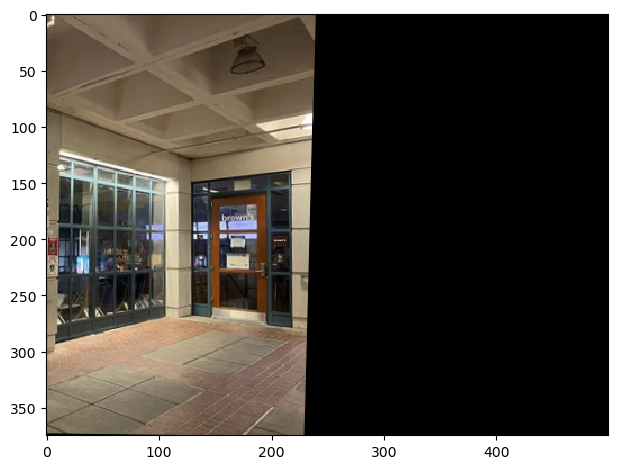

In [100]:
hallway0_hallway1 = ImagePointSet("hallway/hallway0_hallway1.json")
hallway0_hallway1_projection_matrix = computeProjectionMatrix(hallway0_hallway1.points[0], hallway0_hallway1.points[1])
wrapped_image = wrap_image_with_cv2(hallway0_hallway1.images[0], hallway0_hallway1_projection_matrix)
print(hallway0_hallway1.images[0].shape, wrapped_image.shape)
skio.imshow(wrapped_image)
skio.show()